# Decoder for DA clamp

In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

In [ ]:
# Load the data
folder_path = '/Users/shunli/Desktop/EP-LHb-model/DA clamp/Dataset'
files = os.listdir(folder_path)
file_path = [os.path.join(folder_path, file) for file in files]
animal1 = [file for file in file_path if 'Reward1' in file]
animal2 = [file for file in file_path if 'Reward2' in file]
animal3 = [file for file in file_path if 'Reward3' in file]

control = animal1 + animal2
inhibition = animal3

## Train decoder using photometry data from control animal

In [4]:
# Use control group to train the model
for file in control:
    signals, water_lick = [],[]
    with h5py.File(file, 'r') as f:
        signals.append(f['photometry_reshape'][:])
        water_lick.append(f['waterLick_reshape'][:])

signals = np.concatenate(signals, axis=0).T
water_lick = np.concatenate(water_lick, axis=0)
labels = np.squeeze(water_lick.T)

In [6]:
# Upsample the minority class so that sample contains more instance of reward lick

idx_positive = np.where(labels == 1)[0]
idx_negative = np.where(labels == 0)[0]

idx_upsampled = np.random.choice(idx_positive, size=len(idx_negative), replace=True)
idx_combined = np.concatenate([idx_negative, idx_upsampled])
np.random.shuffle(idx_combined)
signals = signals[idx_combined]
labels = labels[idx_combined]
print("Number of non-zero labels: ", np.count_nonzero(labels == 1))
print("Number of zero labels: ", np.count_nonzero(labels == 0))

Number of non-zero labels:  2688
Number of zero labels:  2688


In [7]:
# train sets vs test sets
X_train, X_test, y_train, y_test = train_test_split(signals, labels, test_size=0.2, random_state=42)
# train sets vs validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train_scaled, y_train)

# Evaluate on the validation set
y_val_pred = model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluate on the test set
y_test_pred = model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Validation Accuracy: 100.00%
Test Accuracy: 99.81%


Test AUC: 1.00


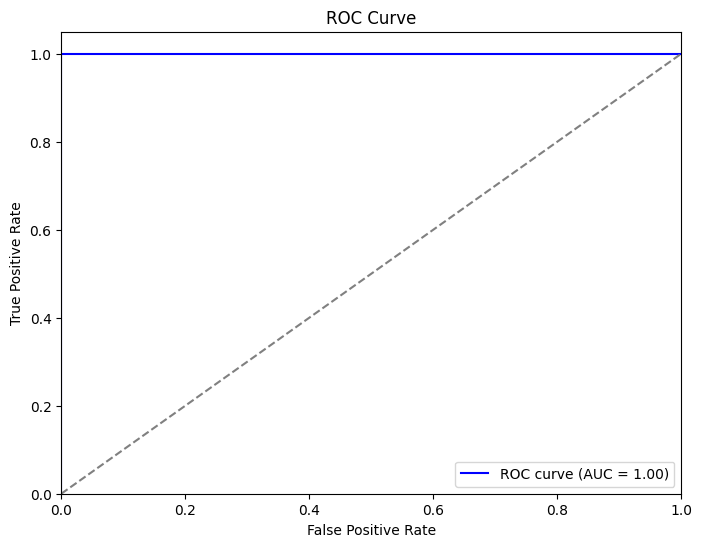

In [10]:
#  ROC curve and AUC
# Probabilities for the positive class (1)
y_test_prob = model.predict_proba(X_test_scaled)[:, 1]  
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)
print(f"Test AUC: {roc_auc:.2f}")
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

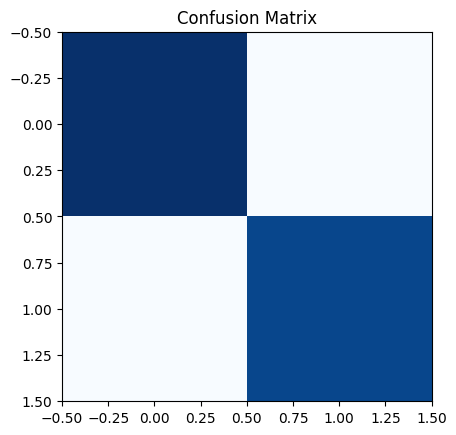

In [18]:
# Confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred)

plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')

In [19]:
# shuffle the data to avoid any bias and get a baseline accuracy
print(np.count_nonzero(labels == 1), np.count_nonzero(labels == 0))
np.random.shuffle(labels)
X_train, X_test, y_train, y_test = train_test_split(signals, labels, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Accuracy: {accuracy * 100:.2f}%")

2688 2688
Baseline Accuracy: 49.54%


## Apply decoder to photometry recording with PID

In [20]:
with h5py.File(inhibition[0], 'r') as f:
    signals = f['photometry_reshape'][:]
    water_lick = f['waterLick_reshape'][:]

signals = signals.T
labels = np.squeeze(water_lick.T)
print(signals.shape, labels.shape)

(2789, 10000) (2789,)


In [21]:
# Standardize the features (important for logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(signals)

y_pred = model.predict(X_scaled)
test_accuracy = accuracy_score(y_pred, labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 43.03%


Test AUC: 0.47


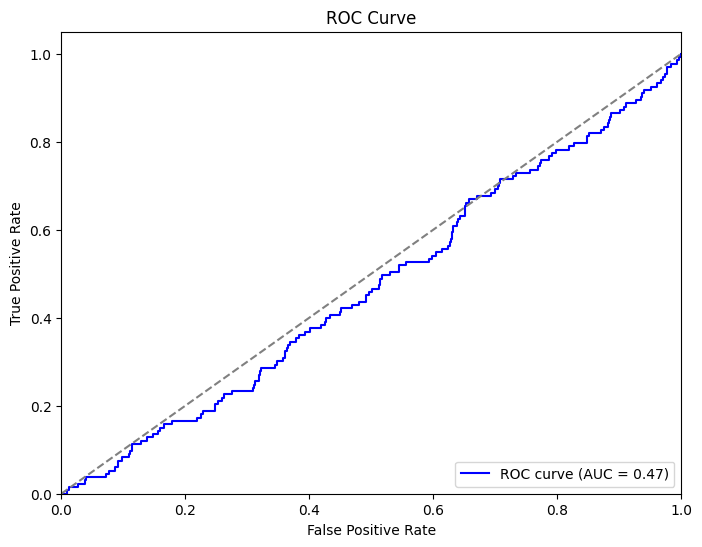

In [ ]:
# ROC curve and AUC
y_prob = model.predict_proba(X_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(labels, y_prob)
roc_auc = auc(fpr, tpr)
print(f"Test AUC: {roc_auc:.2f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred)

plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')

## Genrate a PID only decoder

In [29]:
with h5py.File(inhibition[0], 'r') as f:
    signals = f['photometry_reshape'][:]
    water_lick = f['waterLick_reshape'][:]

signals = signals.T
labels = np.squeeze(water_lick.T)
print(signals.shape, labels.shape)

(2789, 10000) (2789,)


In [30]:
# Upsample the minority class so that sample contains more instance of reward lick
idx_positive = np.where(labels == 1)[0]
idx_negative = np.where(labels == 0)[0]

idx_upsampled = np.random.choice(idx_positive, size=len(idx_negative), replace=True)
idx_combined = np.concatenate([idx_negative, idx_upsampled])
np.random.shuffle(idx_combined)
signals = signals[idx_combined]
labels = labels[idx_combined]
print("Number of non-zero labels: ", np.count_nonzero(labels == 1))
print("Number of zero labels: ", np.count_nonzero(labels == 0))

Number of non-zero labels:  2656
Number of zero labels:  2656


In [31]:
# train sets vs test sets
X_train, X_test, y_train, y_test = train_test_split(signals, labels, test_size=0.2, random_state=42)
# train sets vs validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [32]:
# Logistic Regression model
pid_model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train_scaled, y_train)

# Evaluate on the validation set
y_val_pred = model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluate on the test set
y_test_pred = model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Validation Accuracy: 99.53%
Test Accuracy: 99.72%
